# Investigating K-fold Cross Validation

# TOC
___
[Sect.1: Introduction](#Sect.1)

[Sect.2: Linear Regression Model](#Sect.2)

[Sect.3: Linear Regression Model on Census Data ](#Sect.3)

[Sect.4: K-fold Cross Validation](#Sect.4)

[Sect.5: Comparison with Leave One Out Validation](#Sect.5)

# Sect.1
# Introduction
[Back to top](#TOC)

# Sect.2
# Linear Regression Model
[Back to top](#TOC)

In this section we will:
- Import Census population data
- Set up methods to create a linear regression model based on training data inputted with expected target values

In [ ]:
#Import
import pandas as pd
import numpy as np
import seaborn as sns
import random

### Least squares estimator

$$y = \beta X + \epsilon $$

Least Squares Estimator (Best Linear Unbiased Estimator) of model parameters (Wasserman p217):

$$ \hat{\beta} = (X'X)^{-1}(X'Y)$$

In [ ]:
def linear_regression(x_train, y_train):
    '''
    input: x_train (arraylike, size: n x p)
            y_train (arraylike, size: n x 1)
            
    Uses the least squares estimator to create a model (b_hat) which is returned 
    
    output: b_hat (arraylike, size p x 1)
    '''
    x_prime = x_train.T
    
    # TEST
    print("X train: \n", x_train)
    print(" Y train: \n", y_train)
    print("x_prime: \n", x_prime)
    
    # Calculate the Least Squares Estimates of model coefficients
    # B_hat = ( X'X)^-1 X'Y
    first_term = np.linalg.inv( np.matmul(x_prime, x_train) )
    second_term = np.matmul(first_term , x_prime)
    B_hat = np.matmul( second_term ,  y_train)
    
    return B_hat

To test the linear regression model, we will use a linear dataset and try to find the original parameters of the generating model:

### Make dataset to test lin reg

In [ ]:
def prepare_inputs(y_train, *x_trains):
    '''
    Takies in np.arrays y_train, and 1+ x_trains 
    
    It checks if the y_train and x_train are the same length
    
    then it transposes the y_train and 
    '''
    first_col = x_trains[0]
    for col in x_trains:
        assert(len(first_col) == len(col))
    
    # Join x_train columns
    input_vars = np.array(x_trains)
    
    # Transpose
    input_vars = np.transpose(input_vars)
    
    # Add extra column of ones
    ones_col = np.transpose(np.matrix(np.ones(first_col.shape[0])))
    input_vars = np.append(ones_col,input_vars,  axis=1)
    
    # Transpose y train
    y_train = np.transpose(np.matrix(y_train))
    
    return input_vars, y_train

 

In [ ]:
# Suppose we have a generating function which takes 2 input variables (x,z) to 
# to make a target variable y:
# y =  3x + 2z + 5 + E (noise)

x = np.array([1,5,6,3,2]) #+ np.array([np.random.normal() for _ in range(len(x))])
z =  np.array([2,5,3,11,6]) 
y = 3*x + 2*z + 5 + np.array([np.random.normal() for _ in range(len(x))])

input_vars, y_train= prepare_inputs(y, x, z )

input_vars, y_train

### Create Lin Reg Model

In [ ]:
B_hat = linear_regression(input_vars, y_train)

print(f"Estimate of model parameters (B_hat):\n {B_hat}")

### Predict using Lin Reg Model

In [ ]:
def predict(model, x_pred):
    '''
    input: model (arraylike, size: p x 1)
            x_pred (arraylike, size m x p)
            
    Uses the least squares estimator model (b_hat) from the linear_regression function to 
    make a prediction for what the output set (y_pred) would be given a certain input set (x_pred)
    
    [y_pred] = [x_pred] * [b_hat] 
    asserts that the num. columns in x_pred = the rows of the model (p)
    
    output: y_pred (arraylike, size m x 1)
    '''
    print("Model shape: ", model.shape)
    print("Input shape: " , x_pred.shape)
    assert(model.shape[0] == x_pred.shape[1])
    y_pred = np.matmul(x_pred, model)
    
    return np.matrix(y_pred)

In [ ]:
# Test what model predicts for new inputs:
x_pred = np.array([1,2,3,6,4,7]) #+ np.array([np.random.normal() for _ in range(len(x))])
z_pred =  np.array([5,6,7,8,9,10]) 
y_pred = 3*x_pred + 2*z_pred + 5 + np.array([np.random.normal() for _ in range(len(x_pred))])

input_vars, y_train= prepare_inputs(y_pred, x_pred, z_pred)

input_vars, y_train

In [ ]:
# Try to preditct:
y_prediction = predict(B_hat , input_vars)
y_prediction_matrix = zip(y_prediction, y_train)

print(f"predicted\t actual \t\t diff")
MSE = 0
for y_p , y_t in y_prediction_matrix:
    error = y_p[0] -y_t[0]
    MSE +=  error**2
    print(f"{y_p[0]}\t{y_t[0]}\t{error}")

print("MSE is :", MSE/len(y_prediction))

### Calculating MSPE of prediction

In [ ]:
def MSPE(y_predicted, y_train):
    '''
    Mean Square Predictiona error:
    
    input: y_predicted (arraylike, size: m x 1)
           y (arraylike, size m x 1)
            
    Finds the sum of squared differences between the predicted y values in the training set
    and the observed y_train values
    '''
  
    assert(len(y_predicted) == len(y_train))
    
    errors = np.subtract(y_predicted , y_train)
    
    print("Y pred:\n", y_predicted)
    print("Y train:\n", y_train)
    
    # MSPE = (predicted - actual)**2 / n
    mean_error = np.matmul( errors.T, errors) / len(y_train)
    print("Mean squared errors: ", mean_error)
    
    '''
    #print side by side - BETTER
    print(f"predicted\t actual \t\t diff")
    MSE = 0
    for y_p , y_t in y_prediction_matrix:
        error = y_p[0] -y_t[0]
        MSE +=  error**2
        print(f"{y_p[0]}\t{y_t[0]}\t{error}")

    print("MSE is :", MSE/len(y_prediction))
    '''
    
    return errors,mean_error[0,0]

In [ ]:
# Find MSPE of the estimates:

MSPE_errors, error = MSPE(y_prediction, y_train )
print("Mean Squared Prediction Error: ", error)
MSPE_errors, error

# Sect.3
# Linear Regression Model on Census Data

Taking the census data from 2010, we wi

Census Dataset:
For the years of 2010 to 2015 they have the following data for each county:
- Births
- Deaths
- Net migration
- NATURALINC2010  = Births - deaths

[Back to top](#TOC)

In [ ]:
# Import Census data from CSV
census = pd.read_csv("census.csv")
census.describe()

In [ ]:
# Select ONLY County level rows

census_counties = census[census["SUMLEV"] == 50]

print("Sum of 2010 census populations by counties: " , sum(census_counties["CENSUS2010POP"]))
census_counties["STNAME"].value_counts().sort_index()
# 51 states - States + DC

In [ ]:
columns10 = [x for x in census.columns if x.endswith("2010")]
columns11 = [x for x in census.columns if x.endswith("2011")]

In [ ]:
census_counties.to_clipboard()


In [ ]:
# Figuring out how the fields relate
autauga = census_counties.iloc[0]

autauga["CENSUS2010POP"]
print("Name: ", autauga["CTYNAME"])
print(f"~"*50)
print( autauga["CENSUS2010POP"], " = Census 2010 pop ")
print( autauga["BIRTHS2010"], " = Births 2010 pop ")
print( autauga["DEATHS2010"], " = Deaths 2010 pop ")
print( autauga["NETMIG2010"], " = Net Migration 2010 pop ")

print( autauga["NPOPCHG_2010"], " = Pop Change 2010")
autauga.to_clipboard()
autauga[columns10].to_clipboard()


In [ ]:
autauga[columns11].to_clipboard()

In [ ]:
input_vars, y_train= prepare_inputs(y_pred, x_pred, z_pred)

input_vars, y_train

# Sect.3
# Linear Regression Model on Heart Disease Data

Heart Disease Dataset:
- age
- sex
- cp
- trestbps
- chol
- fbs
- restecg
- thalach
- exang
- oldpeak
- slope
- ca
- thal
- target
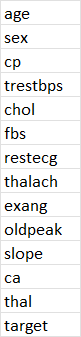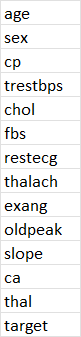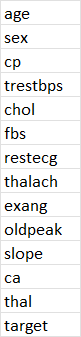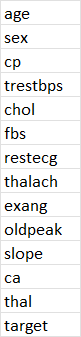

[Back to top](#TOC)

In [ ]:
# Import HEART data from CSV
heart = pd.read_csv("heart.csv")
heart.describe()

In [ ]:
heart_subset = heart[['age','sex','target']]
sns.pairplot(heart_subset, hue = 'target')

In [ ]:
# Try to run the linear regression on the heart subset data

heart_subset_X = heart_subset.iloc[:,:2]

heart_subset_Y = heart_subset.iloc[:,2]


heart_subset_X, heart_subset_Y

In [ ]:
# RUN LIN REG ON HEART SUBSET

B_hat = linear_regression( heart_subset_X, heart_subset_Y)

print(f"Estimate of model parameters (B_hat):\n {B_hat}")

In [205]:
y_prediction = np.ravel(y_prediction)
for index in range(len(y_prediction)):
    if(y_prediction[index]>=0.5):
        y_prediction[index] = 1
    else:
        y_prediction[index] = 0
    
y_prediction


array([0., 0., 1., ..., 0., 1., 0.])

In [206]:
heart_subset_Y,
# Try to preditct:
y_prediction = predict(B_hat , heart_subset_X)
y_prediction_matrix = zip(y_prediction.T, np.matrix(heart_subset_Y).T)

# Convert to 1 and 0 predictions
y_prediction = np.ravel(y_prediction)
for index in range(len(y_prediction)):
    if(y_prediction[index]>=0.5):
        y_prediction[index] = 1
    else:
        y_prediction[index] = 0
        
        
print(f"predicted\t actual \t\t diff")
MSE = 0
for y_p , y_t in y_prediction_matrix:
    error = y_p[0] -y_t[0]
    MSE +=  error**2
    print(f"{y_p[0]}\t{y_t[0]}\t{error}")

MSE= MSE/len(y_prediction.T)
print("MSE is :", MSE)
print("RMSE is :", np.sqrt(MSE))


Model shape:  (2,)
Input shape:  (1025, 2)
predicted	 actual 		 diff
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]


C:\Users\rsvpr\AppData\Local\Temp\ipykernel_1000\3910148774.py:17: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  y_pred = np.matmul(x_pred, model)


[[1.]]	[[0]]	[[1.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[1]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[1]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[1]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[1.]]	[[1]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[0]]	[[0.]]
[[0.]]	[[1]]	[[-1.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[0]]	[[1.]]
[[0.]]	[[0]]	[[0.]]
[[1.]]	[[0]]	[[1.]]
[[1.]]	[[1]]	[[0.]]
[[0

In [ ]:
MSPE_errors, error = MSPE(y_prediction.T, np.matrix(heart_subset_Y).T )
print("Mean Squared Prediction Error: ", error)
MSPE_errors, error

In [ ]:
len(np.matrix(heart_subset_Y).T)

len(y_prediction.T)

In [ ]:
y_prediction[0][0]

y_prediction.T

In [ ]:
np.matrix(heart_subset_Y).T

# Sect.4
#  K-fold Cross Validation
[Back to top](#TOC)

In [ ]:
# Borrowed from Dr. Stephyn Butcher, "Fundementals of Data Science," p608
'''
input:
xs (list): list to be divided
n (int) : number of folds


output:
xs split into n sub-lists, each with size within 1 of (floor(len(xs)/n))  
'''
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [ ]:
test = pd.DataFrame({"a": range(16)})

indices = list(range(len( test)))

folds = chunk(indices, 5)

folds

In [ ]:
# Borrowed from Dr. Stephyn Butcher, "Fundementals of Data Science," p608
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

# Sect.5
# Comparison with Leave One Out Validation
[Back to top](#TOC)